# Debug det-sim NB

### JAH 3/12/19

In [1]:
import time

%load_ext autoreload
%autoreload 2

import numpy             as np
import scipy             as sc
import scipy.stats       as st
import tables            as tb

from typing    import Callable
from typing    import Tuple
from typing    import List

import invisible_cities.core    .system_of_units_c as system_of_units
import invisible_cities.core    .fit_functions     as fitf
import invisible_cities.database.load_db           as db

import myhistos         as ht
import detsim           as ds
import voxels           as vx

units = system_of_units.SystemOfUnits()

# Plotting configuration

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 5, 4
plt.rcParams["font.size"]               = 12
plt.rcParams["figure.max_open_warning"] = 100

## DetSim

In [3]:
detsimparams = ds.DetSimParameters()

## Generate - drift - diffuse electrons

total energy  41.50719999999999  keV


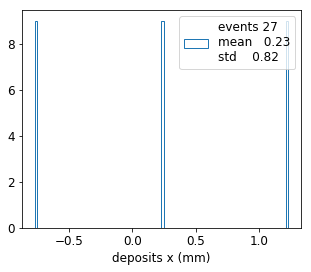

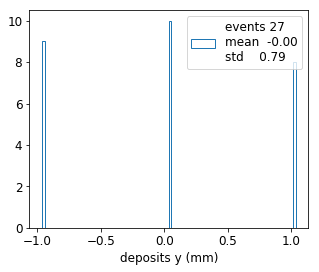

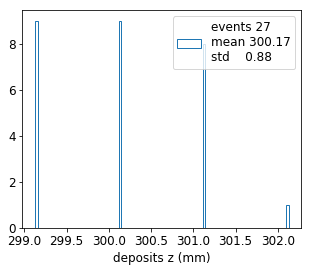

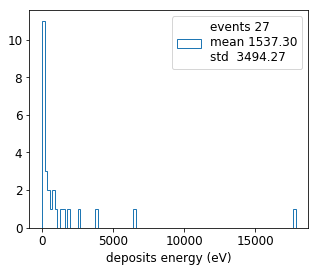

In [4]:
plot = True
# generate deposits
xs, ys, zs, enes = ds.generate_deposits(xsigma = 0.4)
if (plot):
    print('total energy ', np.sum(enes) / units.keV, ' keV')
    ht.hist(xs, 100); plt.xlabel('deposits x (mm)')
    ht.hist(ys, 100); plt.xlabel('deposits y (mm)')
    ht.hist(zs, 100); plt.xlabel('deposits z (mm)')
    ht.hist(enes / units.eV, 100); plt.xlabel('deposits energy (eV)')

total energy  41.5072  keV
number of secondary elctrons  1857
number of drifted electrons  1857
number of diffused electrons  1857
longitudinal diffusion  1.6433758070590068
transverse diffusion 5.477919356863357


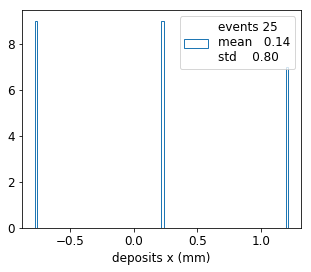

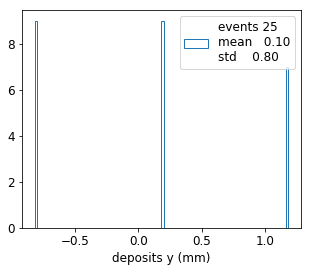

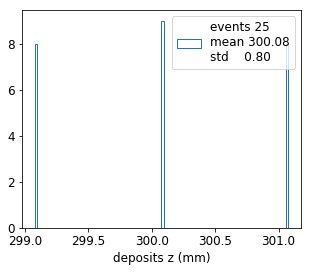

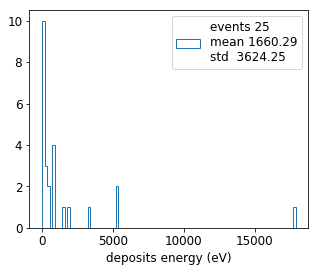

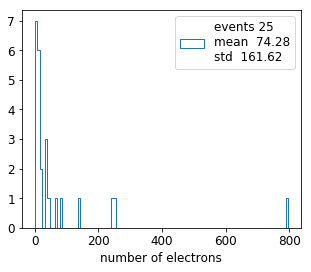

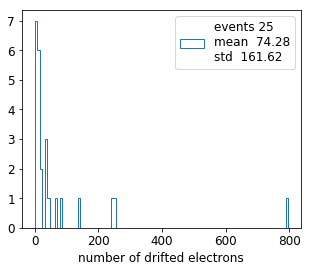

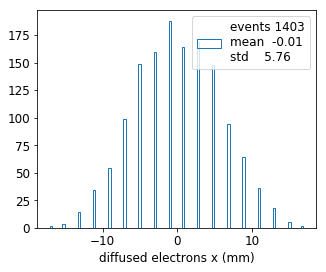

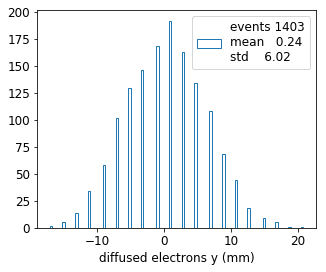

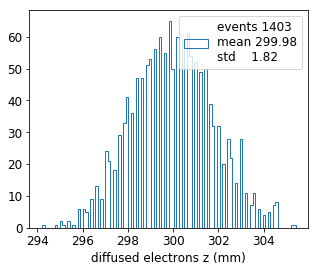

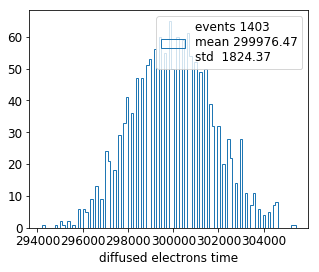

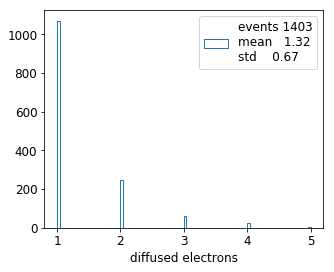

In [5]:
plot = True
# generate deposits
xs, ys, zs, enes = ds.generate_deposits(xsigma = 0.4)
if (plot):
    print('total energy ', np.sum(enes) / units.keV, ' keV')
    ds.histo(xs, 'deposits x (mm)')
    ds.histo(ys, 'deposits y (mm)')
    ds.histo(zs, 'deposits z (mm)')
    ds.histo(enes / units.eV, 'deposits energy (eV)')
    
# generate electrons
nes = ds.generate_electrons(enes)
if (plot):
    print('number of secondary elctrons ', np.sum(nes))
    ht.hist(nes, 100); plt.xlabel('number of electrons')

# drift electrons
nes = ds.drift_electrons(zs, nes)
if (plot):
    print('number of drifted electrons ', np.sum(nes));
    ht.hist(nes, 100); plt.xlabel('number of drifted electrons')

# diffuse electrons
dxs, dys, dzs, dnes = ds.diffuse_electrons(xs, ys, zs, nes)
dts                 = dzs / detsimparams.drift_velocity
if (plot):
    print('number of diffused electrons ', np.sum(nes));
    print('longitudinal diffusion ', detsimparams.longitudinal_diffusion * np.sqrt(np.mean(zs)))
    print('transverse diffusion'   , detsimparams.transverse_diffusion * np.sqrt(np.mean(zs)))
    ht.hist(dxs  , 100); plt.xlabel('diffused electrons x (mm)')
    ht.hist(dys  , 100); plt.xlabel('diffused electrons y (mm)')
    ht.hist(dzs  , 100); plt.xlabel('diffused electrons z (mm)')
    ht.hist(dts  , 100); plt.xlabel('diffused electrons time')
    ht.hist(dnes , 100); plt.xlabel('diffused electrons')

number of EL photons 1857375.712664025
pes  [18498.27060856 18498.27060856 18498.27060856 18498.27060856
 18498.27060856 18498.27060856 18498.27060856 18498.27060856
 18498.27060856 18498.27060856 18498.27060856 18498.27060856]
pes  [0.49314808 0.52802874 0.56529045 ... 0.56337878 0.52628115 0.49155177]


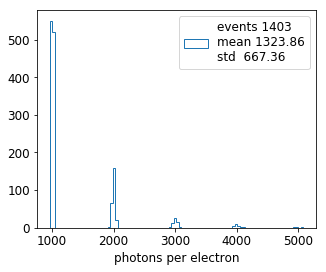

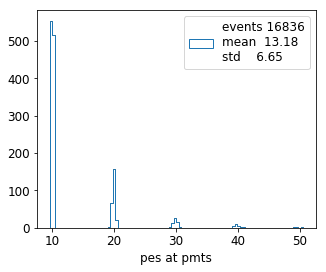

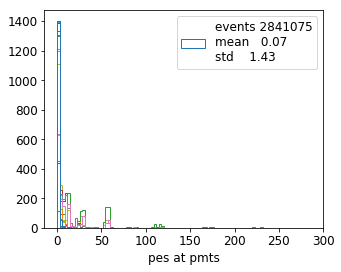

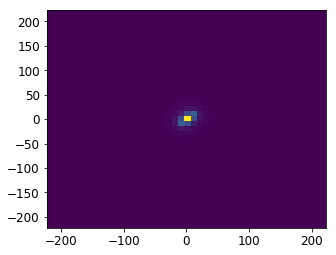

In [6]:
photons = ds.generate_EL_photons(dnes)
if (plot):
    print('number of EL photons', np.sum(photons))
    ht.hist(photons, 100); plt.xlabel('photons per electron');

pes_pmts = ds.estimate_pes_at_pmts(dxs, dys, photons)
if (plot):
    print('pes ', np.sum(pes_pmts, axis = 0))
    ht.hist(pes_pmts, 100); plt.xlabel('pes at pmts')
    
pes_sipms = ds.estimate_pes_at_sipms(dxs, dys, photons)
if (plot):
    print('pes ', np.sum(pes_sipms, axis = 0))
    ht.hist(pes_sipms, 100); plt.xlabel('pes at pmts')
    
    plt.figure();
    int_pes_sipms  = np.sum(pes_sipms, axis = 0)
    plt.hist2d(detsimparams.x_sipms, detsimparams.y_sipms, bins = detsimparams.xybins, weights = int_pes_sipms);

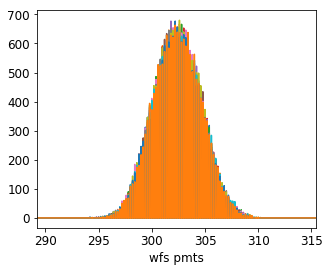

In [7]:
times_pmts, wfs_pmts = ds.create_wfs_pmts(dts, pes_pmts)
#print(times_pmts.shape, wfs_pmts.shape)
if (plot):
    xcenters = times_pmts
    plt.plot(xcenters / units.mus, wfs_pmts.T); plt.xlabel('wfs pmts')
    plt.xlim((np.min(dts) /units.mus - 5, np.max(dts) / units.mus + 10));

(1001,) (2025, 1001)


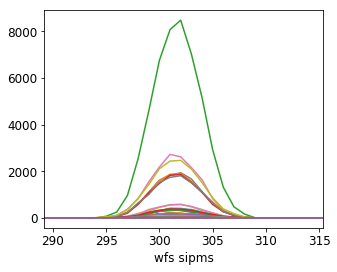

In [9]:
times_sipms, wfs_sipms = ds.create_wfs_sipms(dts, pes_sipms)
if (plot):
    xcenters = times_sipms
    plt.plot(xcenters / units.mus, wfs_sipms.T); plt.xlabel('wfs sipms')
    plt.xlim((np.min(dts) /units.mus - 5, np.max(dts) / units.mus + 10));

## One go

In [13]:
def simulate_tracks(x0 = 0, y0 = 0, z0 = 300 * units.mm, tx = 0.2, ty = -0.1, 
                    ene = 511 * units.keV, dz = 2 * units.mm):
    
    nsteps = int((ene  - (150 * units.keV)) / (4.4 * units.keV))
    nsteps = max(nsteps , 1)
    xs = x0 + tx * dz * np.arange(nsteps + 1) 
    ys = y0 + ty * dz * np.arange(nsteps + 1)
    zs = z0 + dz * dz * np.arange(nsteps + 1)
    enes = (4.4 * units.keV) * np.ones(nsteps + 1)
    enes[-1] += (ene - np.sum(enes))

    return xs, ys, zs, enes
    

In [14]:
xs, ys, zs, enes = simulate_tracks()
print(xs)
print(xs)
print(zs)
print(enes, np.sum(enes))

[ 0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8  5.2
  5.6  6.   6.4  6.8  7.2  7.6  8.   8.4  8.8  9.2  9.6 10.  10.4 10.8
 11.2 11.6 12.  12.4 12.8 13.2 13.6 14.  14.4 14.8 15.2 15.6 16.  16.4
 16.8 17.2 17.6 18.  18.4 18.8 19.2 19.6 20.  20.4 20.8 21.2 21.6 22.
 22.4 22.8 23.2 23.6 24.  24.4 24.8 25.2 25.6 26.  26.4 26.8 27.2 27.6
 28.  28.4 28.8 29.2 29.6 30.  30.4 30.8 31.2 31.6 32.  32.4 32.8]
[ 0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8  5.2
  5.6  6.   6.4  6.8  7.2  7.6  8.   8.4  8.8  9.2  9.6 10.  10.4 10.8
 11.2 11.6 12.  12.4 12.8 13.2 13.6 14.  14.4 14.8 15.2 15.6 16.  16.4
 16.8 17.2 17.6 18.  18.4 18.8 19.2 19.6 20.  20.4 20.8 21.2 21.6 22.
 22.4 22.8 23.2 23.6 24.  24.4 24.8 25.2 25.6 26.  26.4 26.8 27.2 27.6
 28.  28.4 28.8 29.2 29.6 30.  30.4 30.8 31.2 31.6 32.  32.4 32.8]
[300. 304. 308. 312. 316. 320. 324. 328. 332. 336. 340. 344. 348. 352.
 356. 360. 364. 368. 372. 376. 380. 384. 388. 392. 396. 400. 404. 408.
 412. 416. 420. 

number of secondary elctrons  22825
number of drifted electrons  22810
number of diffused electrons  22810
longitudinal diffusion  2.043526363911168
transverse diffusion 6.81175454637056
number of EL photons 22809987.303106293
pes  [226180.71876631 226180.71876631 226180.71876631 226180.71876631
 226180.71876631 226180.71876631 226180.71876631 226180.71876631
 226180.71876631 226180.71876631 226180.71876631 226180.71876631]
pes  [4.66159895 4.96444628 5.2863904  ... 9.74713895 9.02952409 8.36307719]
timing generate, pes, wfs 0.5704870223999023 12.192030906677246 10.506940841674805  s


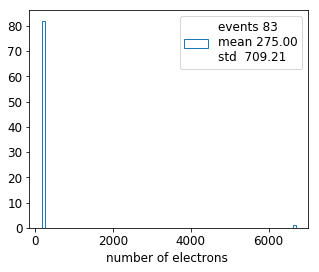

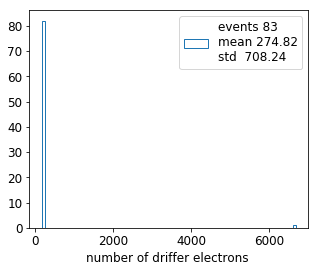

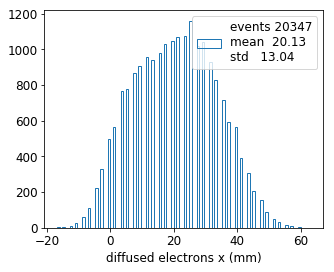

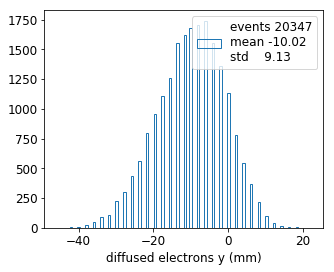

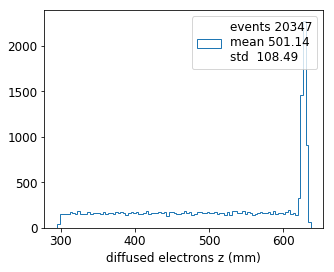

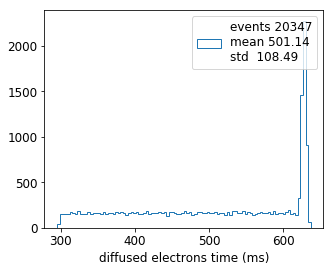

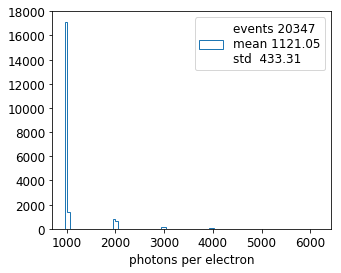

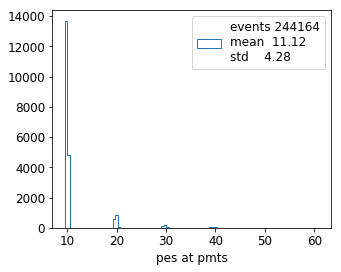

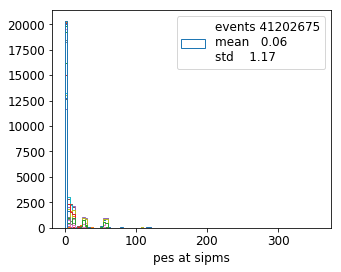

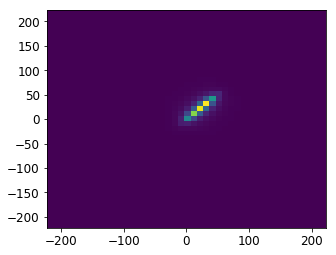

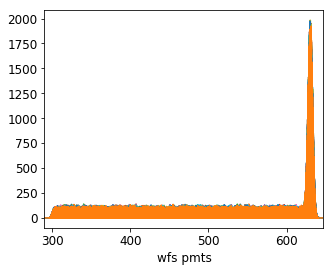

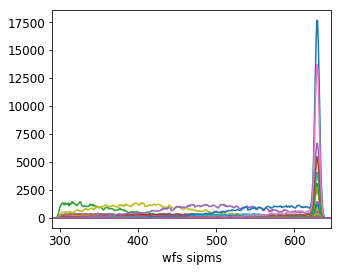

In [15]:
#energy = 41.5. * units.keV
#size = int(energy  / detsimparams.wi)
#xs, ys, zs, enes = ds.generate_deposits(xsigma = 5., size = size )
data = ds.generate_wfs(xs, ys, zs, enes, histos = True)

In [17]:
def time_to_simulate_one_event(xs, ys, zs, enes, n = 1):
    t0 = time.time()
    for i in range(n):
        ds.generate_wfs(xs, ys, zs, enes)
    return (time.time() - t0) / n

In [18]:
dtsim = time_to_simulate_one_event(xs, ys, zs, enes, n = 10)
print('total ', dtsim, 's')

total  12.788150024414062 s
